# Data Analysis of Flux Simulation Data

In [3]:
import pyarrow.parquet as pq
import pandas as pd
import json
import os
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt

A numerical simulation creates datafile in the [Parquet file format](https://parquet.apache.org/documentation/latest/).  

In [4]:
files = glob("data/*.parquet")
files

['data/2022-03-01--11-09-27.parquet',
 'data/2022-03-01--11-20-52.parquet',
 'data/2022-03-01--11-06-57.parquet',
 'data/2022-03-01--11-11-11.parquet',
 'data/2022-03-01--11-18-05.parquet',
 'data/2022-03-01--11-23-15.parquet',
 'data/2022-03-01--11-21-56.parquet',
 'data/2022-03-01--11-24-59.parquet',
 'data/2022-03-01--11-13-57.parquet',
 'data/2022-03-01--11-08-07.parquet',
 'data/2022-03-01--11-16-21.parquet',
 'data/2022-03-01--11-15-02.parquet']

We can use `pd.read_parquet` to read the data and `pq.read_schema` to read the metadata.  For this set of simulations, the parameters `Pe` and `SS` are the only ones changing between simulations. We create a multidimensional Xarray dataset to hold the output from each experiment with the parameters serving as dimensions.

In [30]:
def load_parquet_data(file):
    # load parquet file as pandas dataframe
    df = pd.read_parquet(file)
    # remove multi-index on column
    df = df.droplevel(level=0, axis=1)
    # convert to a Xarray Dataset
    # ds = xr.Dataset(df)
    ds = xr.DataArray(df, dims=['Time','DiffusiveFlux']) # use xr.DataArray instead

    # metadata is also stored in the parquet file
    def DictFilter(x,y):
        """Slice dict. Usage: dictfilter(originaldict, [dictkeystokeep])"""
        return dict([ (i,x[i]) for i in x if i in set(y)])

    schema = pq.read_schema(file)
    metadata = json.loads(schema.metadata[b'metadata'])

    mdata = metadata['updatedparameters'][0] if 'updatedparameters' in metadata.keys() else metadata['yaml'][0]
    mdata = DictFilter(mdata, ['Mesh','Parameters'])
    mdata.update({'Simulation': metadata['simulation']})

    mesh_metadata = mdata['Mesh']
    parameters_metadata = mdata['Parameters']
    simulation_metadata = mdata['Simulation']

    # Pull out variables that are changing between experiments
    Pe = parameters_metadata['Pe']
    SS = mesh_metadata['SS']

    # Add new dimensions for the changing parameters
    ds = ds.expand_dims(['Pe', 'SS', 'mesh'])
    ds['Pe'] = [Pe]
    ds['SS'] = [SS]
    ds['mesh'] = [simulation_metadata['mesh']]

    # remove those parameters from the shared list of parameters
    del parameters_metadata['Pe']
    del mesh_metadata['SS']
    
    # nx: None will not be storable in a NetCDF file. Remove it.
    if 'nx' in mesh_metadata and mesh_metadata['nx'] is None:
        del mesh_metadata['nx']
    # NetCDF does not support boolean for attribute data type
    if 'override' in mesh_metadata:
        mesh_metadata['override'] = int(mesh_metadata['override'])
        
    ds = ds.assign_attrs(mesh_metadata)
    ds = ds.assign_attrs(parameters_metadata)
    ds = ds.assign_attrs(simulation_metadata)

    ds.name = '_Dataset_'+simulation_metadata['timestamp'].replace("-", "_")  # xr.dataArray will need unique name to merge with others later on
    
    return ds

As an example, here one of the data files transformed into a Xarray dataset.

In [31]:
ds = load_parquet_data(files[0])
ds

<xarray.DataArray '_Dataset_2022_03_01__11_09_27' (Pe: 1, SS: 1, mesh: 1,
                                                   Time: 62, DiffusiveFlux: 7)>
array([[[[[-2.86157774e+01,  0.00000000e+00,  1.13830822e-01,
           -1.09388662e-01, -0.00000000e+00, -0.00000000e+00,
           -0.00000000e+00],
          [-2.07506505e+01,  0.00000000e+00,  1.09858766e-01,
           -4.52373368e-02,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00],
          [-1.50636713e+01, -0.00000000e+00,  1.14380130e-01,
           -5.05665598e-03, -0.00000000e+00, -0.00000000e+00,
            0.00000000e+00],
          [-1.10354845e+01,  0.00000000e+00,  1.22391799e-01,
            2.55549752e-02,  0.00000000e+00,  0.00000000e+00,
           -0.00000000e+00],
          [-8.23001762e+00, -0.00000000e+00,  1.32295873e-01,
            5.15059679e-02, -0.00000000e+00, -0.00000000e+00,
            0.00000000e+00],
          [-6.29595038e+00,  0.00000000e+00,  1.43383358e-01,
            7.47579860e-02,  0.00000000e+00,  0.00000000e+00,
           -0.00000000e+00],
          [-4.96421331e+00, -0.00000000e+00,  1.55254428e-01,
            9.62333277e-02, -0.00000000e+00, -0.00000000e+00,
...
            1.73733868e+00,  1.02281330e+01,  5.91947616e+00,
            4.30865681e+00],
          [ 3.42000000e-14,  1.45555842e-02,  2.11813282e-01,
            1.68157783e+00,  1.02283617e+01,  5.91947680e+00,
            4.30888491e+00],
          [ 3.58000000e-14,  6.91602043e-03,  1.02924334e-01,
            1.65582598e+00,  1.02283887e+01,  5.91947684e+00,
            4.30891190e+00],
          [ 3.75000000e-14,  2.23165774e-03,  4.03390949e-02,
            1.64676684e+00,  1.02283909e+01,  5.91947685e+00,
            4.30891405e+00],
          [ 3.75000000e-14, -1.85773697e-04,  1.10949168e-02,
            1.64438758e+00,  1.02283910e+01,  5.91947685e+00,
            4.30891417e+00],
          [ 3.75000000e-14, -1.13718850e-03,  1.00870015e-03,
            1.64396197e+00,  1.02283910e+01,  5.91947685e+00,
            4.30891417e+00],
          [ 3.75000000e-14, -1.40729558e-03, -1.45711526e-03,
            1.64391155e+00,  1.02283910e+01,  5.91947685e+00,
            4.30891417e+00]]]]])
Coordinates:
  * Time           (Time) float64 0.0001 0.0002 0.0003 ... 0.175 0.1938 0.2147
  * DiffusiveFlux  (DiffusiveFlux) object 'L' 'R' 'T' 'B' 'S' 's1' 's2'
  * Pe             (Pe) float64 100.0
  * SS             (SS) float64 1.0
  * mesh           (mesh) <U16 'Mesh_v5225_c9984'
Attributes:
    S:          8
    L:          1.0
    H:          1
    nS:         2
    Snx:        26
    T:          0.2147
    dt:         0.0001
    c0:         1.0
    λ:          1.0
    ϵ:          0.025
    Da:         5000000.0
    Ck:         5000000.0
    θ:          0.5
    timestamp:  2022-03-01--11-09-27
    mesh:       Mesh_v5225_c9984

These datasets can be merged into one large dataset.

In [32]:
ds = xr.merge([load_parquet_data(f) for f in files], combine_attrs='drop_conflicts') # combine_attrs='drop_conflicts' so that only common metadata is shown for collection of datasets
ds

<xarray.Dataset>
Dimensions:                        (Time: 67, Pe: 4, SS: 3, DiffusiveFlux: 7,
                                    mesh: 1)
Coordinates:
  * Time                           (Time) float64 0.0001 0.0002 ... 0.3232 0.358
  * Pe                             (Pe) float64 50.0 100.0 150.0 200.0
  * SS                             (SS) float64 1.0 2.0 3.0
  * DiffusiveFlux                  (DiffusiveFlux) object 'L' 'R' ... 's1' 's2'
  * mesh                           (mesh) <U16 'Mesh_v5225_c9984'
Data variables:
    _Dataset_2022_03_01__11_09_27  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_20_52  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_06_57  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_11_11  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_18_05  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_23_15  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_21_56  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_24_59  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_13_57  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_08_07  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_16_21  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_15_02  (Pe, SS, mesh, Time, DiffusiveFlux) float64 ...
Attributes: (12/13)
    S:        8
    L:        1.0
    H:        1
    nS:       2
    Snx:      26
    dt:       0.0001
    ...       ...
    λ:        1.0
    ϵ:        0.025
    Da:       5000000.0
    Ck:       5000000.0
    θ:        0.5
    mesh:     Mesh_v5225_c9984

In [33]:
# When analyzing data it is important to know where each subset of the dataset comes from
# That is, we need to be able to extract metadata for each individual simulation
# Notice "Attributes" above is for the entire collection.

# The solution to merging problem is to merge a list of xr.DataArray objects rather than a list of xr.Dataset

# The attributes for indivual simulations is retained and can be extracted from the dataset.
# Notice that you can click the "show/hide attributes" icon for each data variable.

# The attributes for each dataArray in the xr.dataset can be accessed as follows
print(ds._Dataset_2022_03_01__11_06_57.attrs)

# However, the data does not have a structure very useful for analysis.

{'S': 8,
 'L': 1.0,
 'H': 1,
 'nS': 2,
 'Snx': 26,
 'T': 0.1426,
 'dt': 0.0001,
 'c0': 1.0,
 'λ': 1.0,
 'ϵ': 0.025,
 'Da': 5000000.0,
 'Ck': 5000000.0,
 'θ': 0.5,
 'timestamp': '2022-03-01--11-06-57',
 'mesh': 'Mesh_v5225_c9984'}

The NaNs are occuring because some simulations stopped earlier than others. This can be fixed by filling or padding the data.
We can store the complete dataset as a single NetCDF file.

In [34]:
if os.path.exists("data.nc"):
    os.remove("data.nc")
    
ds.to_netcdf("data.nc")

For future analysis, we can just load this NetCDF file directly and skip the building of the NetCDF file.

In [35]:
ds = xr.open_dataset("data.nc")
ds

<xarray.Dataset>
Dimensions:                        (Time: 67, Pe: 4, SS: 3, DiffusiveFlux: 7)
Coordinates:
  * Time                           (Time) float64 0.0001 0.0002 ... 0.3232 0.358
  * Pe                             (Pe) float64 50.0 100.0 150.0 200.0
  * SS                             (SS) float64 1.0 2.0 3.0
  * DiffusiveFlux                  (DiffusiveFlux) object 'L' 'R' ... 's1' 's2'
Data variables:
    _Dataset_2022_03_01__11_09_27  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_20_52  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_06_57  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_11_11  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_18_05  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_23_15  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_21_56  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_24_59  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_13_57  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_08_07  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_16_21  (Pe, SS, Time, DiffusiveFlux) float64 ...
    _Dataset_2022_03_01__11_15_02  (Pe, SS, Time, DiffusiveFlux) float64 ...
Attributes: (12/13)
    S:        8
    L:        1.0
    H:        1
    nS:       2
    Snx:      26
    dt:       0.0001
    ...       ...
    λ:        1.0
    ϵ:        0.025
    Da:       5000000.0
    Ck:       5000000.0
    θ:        0.5
    mesh:     Mesh_v5225_c9984

We can select the data from only one experiment by indexing by `Pe` or `SS`:

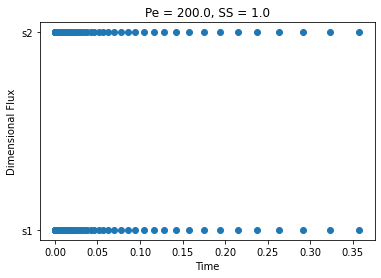

In [59]:
# NOT WORKING
ds.sel(Pe=200, SS=1, DiffusiveFlux=['s1','s2']).plot.scatter(x="Time", y="DiffusiveFlux");
# ds.sel(Pe=200, SS=1).plot.scatter(x="Time", y="s2", label='s2')
plt.ylabel('Dimensional Flux')
plt.show()

# Notebook unchanged past this point. Code beyond here is not expected to run without error

But the real power comes with using `Pe` and `SS` as part of the dataset:

In [ ]:
ds.plot.scatter(x='Time', y='s1', hue='Pe', col='SS')
ds.plot.scatter(x='Time', y='s2', hue='Pe', col='SS')
plt.show()

Or grouping by Pe

In [ ]:
ds.plot.scatter(x='Time', y='s1', hue='SS', col='Pe')
ds.plot.scatter(x='Time', y='s2', hue='SS', col='Pe')
plt.show()

To summarize over all Pe and SS, we can calculate the maximum flux in Time

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ds.s1.max(dim='Time').plot(ax=ax[0])
ax[0].set_title('s1')
ds.s2.max(dim='Time').plot(ax=ax[1])
plt.show()

If you have the Holoviz package installed (hvplot) you can get some instant interactivity:

In [ ]:
import holoviews as hv
hv.extension('bokeh')
import hvplot.xarray

Use the slider to change the value of SS:

In [ ]:
s1 = ds.hvplot.scatter(x='Time', y='s1', by='Pe')
s2 = ds.hvplot.scatter(x='Time', y='s2', by='Pe')
(s1+s2).cols(1)

Or the equilibrium fluxes:

In [ ]:
equlibrium = ds.max("Time")
s1 = equlibrium.hvplot.heatmap(x='SS', y='Pe', C='s1')
s2 = equlibrium.hvplot.heatmap(x='SS', y='Pe', C='s2') 

(s1+s2).cols(1)